In [ ]:
#import utils, torch, time, os, pickle
import torch, time, os, pickle
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.autograd import grad
#from dataloader import dataloader


from torch.utils.data import DataLoader
from torchvision import datasets, transforms

input_size = 28
batch_size = 64
transform = transforms.Compose([transforms.Resize((input_size, input_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])
data_loader = DataLoader(
            datasets.CIFAR10('data/cifar10', train=True, download=True, transform=transform),
            batch_size=batch_size, shuffle=True)

Files already downloaded and verified


In [ ]:
class generator(nn.Module):
    def __init__(self, input_dim=100, output_dim=1, input_size=32):
        super(generator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.fc = nn.Sequential(
            nn.Linear(self.input_dim, 1024),
            #nn.BatchNorm1d(1024),
            #nn.ReLU(),
            nn.LeakyReLU(),
            nn.Linear(1024, 128 * (self.input_size // 4) * (self.input_size // 4)),
            #nn.BatchNorm1d(128 * (self.input_size // 4) * (self.input_size // 4)),
            #nn.ReLU(),
            nn.LeakyReLU(),
        )
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            #nn.ReLU(),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, self.output_dim, 4, 2, 1),
            nn.Tanh(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.fc(input)
        x = x.view(-1, 128, (self.input_size // 4), (self.input_size // 4))
        x = self.deconv(x)

        return x

In [ ]:
class discriminator(nn.Module):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    def __init__(self, input_dim=1, output_dim=1, input_size=32):
        super(discriminator, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_size = input_size

        self.conv = nn.Sequential(
            nn.Conv2d(self.input_dim, 64, 4, 2, 1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * (self.input_size // 4) * (self.input_size // 4), 1024),
            #nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, self.output_dim),
            # nn.Sigmoid(),
        )
        initialize_weights(self)

    def forward(self, input):
        x = self.conv(input)
        x = x.view(-1, 128 * (self.input_size // 4) * (self.input_size // 4))
        x = self.fc(x)

        return x

In [ ]:
# Base GAN
class GAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args['epoch']
        self.sample_num = 100
        self.batch_size = args['batch_size']
        self.save_dir = args['save_dir']
        self.result_dir = args['result_dir']
        self.dataset = args['dataset']
        self.log_dir = args['log_dir']
        self.gpu_mode = args['gpu_mode']
        self.model_name = args['gan_type']
        self.input_size = args['input_size']
        self.z_dim = 62

        # load dataset
        self.data_loader = data_loader#dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args['lrG'], betas=(args['beta1'], args['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args['lrD'], betas=(args['beta1'], args['beta2']))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()
            self.BCE_loss = nn.BCELoss().cuda()
        else:
            self.BCE_loss = nn.BCELoss()

        print('----------       GAN  Type       -------------')
        print(args['gan_type'])
        print('---------- Networks architecture -------------')
        print_network(self.G)
        print_network(self.D)
        print('-----------------------------------------------')


        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()


    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = self.BCE_loss(D_real, self.y_real_)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = self.BCE_loss(D_fake, self.y_fake_)

                D_loss = D_real_loss + D_fake_loss
                self.train_hist['D_loss'].append(D_loss.item())

                D_loss.backward()
                self.D_optimizer.step()

                # update G network
                self.G_optimizer.zero_grad()

                G_ = self.G(z_)
                D_fake = self.D(G_)
                G_loss = self.BCE_loss(D_fake, self.y_real_)
                self.train_hist['G_loss'].append(G_loss.item())

                G_loss.backward()
                self.G_optimizer.step()

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [ ]:
# WGAN
class WGAN(object):
    def __init__(self, args):
        # parameters
        self.epoch = args['epoch']
        self.sample_num = 100
        self.batch_size = args['batch_size']
        self.save_dir = args['save_dir']
        self.result_dir = args['result_dir']
        self.dataset = args['dataset']
        self.log_dir = args['log_dir']
        self.gpu_mode = args['gpu_mode']
        self.model_name = args['gan_type']
        self.input_size = args['input_size']
        self.z_dim = 62
        self.c = 0.01                   # clipping value
        self.n_critic = 5               # the number of iterations of the critic per generator iteration

        # load dataset
        self.data_loader = data_loader#dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args['lrG'], betas=(args['beta1'], args['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args['lrD'], betas=(args['beta1'], args['beta2']))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()

        print('----------       GAN  Type       -------------')
        print(args['gan_type'])
        print('---------- Networks architecture -------------')
        print_network(self.G)
        print_network(self.D)
        print('-----------------------------------------------')

        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                D_loss = D_real_loss + D_fake_loss

                D_loss.backward()
                self.D_optimizer.step()

                # clipping D
                for p in self.D.parameters():
                    p.data.clamp_(-self.c, self.c)

                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))


In [ ]:
# WGAN-GP

class WGAN_GP(object):
    def __init__(self, args):
        # parameters
        self.epoch = args['epoch']
        self.sample_num = 100
        self.batch_size = args['batch_size']
        self.save_dir = args['save_dir']
        self.result_dir = args['result_dir']
        self.dataset = args['dataset']
        self.log_dir = args['log_dir']
        self.gpu_mode = args['gpu_mode']
        self.model_name = args['gan_type']
        self.input_size = args['input_size']
        self.z_dim = 62
        self.lambda_ = 10
        self.n_critic = 5               # the number of iterations of the critic per generator iteration

        # load dataset
        self.data_loader = data_loader#dataloader(self.dataset, self.input_size, self.batch_size)
        data = self.data_loader.__iter__().__next__()[0]

        # networks init
        self.G = generator(input_dim=self.z_dim, output_dim=data.shape[1], input_size=self.input_size)
        self.D = discriminator(input_dim=data.shape[1], output_dim=1, input_size=self.input_size)
        self.G_optimizer = optim.Adam(self.G.parameters(), lr=args['lrG'], betas=(args['beta1'], args['beta2']))
        self.D_optimizer = optim.Adam(self.D.parameters(), lr=args['lrD'], betas=(args['beta1'], args['beta2']))

        if self.gpu_mode:
            self.G.cuda()
            self.D.cuda()

        print('----------       GAN  Type       -------------')
        print(args['gan_type'])
        print('---------- Networks architecture -------------')
        print_network(self.G)
        print_network(self.D)
        print('-----------------------------------------------')

        # fixed noise
        self.sample_z_ = torch.rand((self.batch_size, self.z_dim))
        if self.gpu_mode:
            self.sample_z_ = self.sample_z_.cuda()

    def train(self):
        self.train_hist = {}
        self.train_hist['D_loss'] = []
        self.train_hist['G_loss'] = []
        self.train_hist['per_epoch_time'] = []
        self.train_hist['total_time'] = []

        self.y_real_, self.y_fake_ = torch.ones(self.batch_size, 1), torch.zeros(self.batch_size, 1)
        if self.gpu_mode:
            self.y_real_, self.y_fake_ = self.y_real_.cuda(), self.y_fake_.cuda()

        self.D.train()
        print('training start!!')
        start_time = time.time()
        for epoch in range(self.epoch):
            self.G.train()
            epoch_start_time = time.time()
            for iter, (x_, _) in enumerate(self.data_loader):
                if iter == self.data_loader.dataset.__len__() // self.batch_size:
                    break

                z_ = torch.rand((self.batch_size, self.z_dim))
                if self.gpu_mode:
                    x_, z_ = x_.cuda(), z_.cuda()

                # update D network
                self.D_optimizer.zero_grad()

                D_real = self.D(x_)
                D_real_loss = -torch.mean(D_real)

                G_ = self.G(z_)
                D_fake = self.D(G_)
                D_fake_loss = torch.mean(D_fake)

                # gradient penalty
                alpha = torch.rand((self.batch_size, 1, 1, 1))
                if self.gpu_mode:
                    alpha = alpha.cuda()

                x_hat = alpha * x_.data + (1 - alpha) * G_.data
                x_hat.requires_grad = True

                pred_hat = self.D(x_hat)
                if self.gpu_mode:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()).cuda(),
                                 create_graph=True, retain_graph=True, only_inputs=True)[0]
                else:
                    gradients = grad(outputs=pred_hat, inputs=x_hat, grad_outputs=torch.ones(pred_hat.size()),
                                     create_graph=True, retain_graph=True, only_inputs=True)[0]

                gradient_penalty = self.lambda_ * ((gradients.view(gradients.size()[0], -1).norm(2, 1) - 1) ** 2).mean()

                D_loss = D_real_loss + D_fake_loss + gradient_penalty

                D_loss.backward()
                self.D_optimizer.step()

                if ((iter+1) % self.n_critic) == 0:
                    # update G network
                    self.G_optimizer.zero_grad()

                    G_ = self.G(z_)
                    D_fake = self.D(G_)
                    G_loss = -torch.mean(D_fake)
                    self.train_hist['G_loss'].append(G_loss.item())

                    G_loss.backward()
                    self.G_optimizer.step()

                    self.train_hist['D_loss'].append(D_loss.item())

                if ((iter + 1) % 100) == 0:
                    print("Epoch: [%2d] [%4d/%4d] D_loss: %.8f, G_loss: %.8f" %
                          ((epoch + 1), (iter + 1), self.data_loader.dataset.__len__() // self.batch_size, D_loss.item(), G_loss.item()))

            self.train_hist['per_epoch_time'].append(time.time() - epoch_start_time)
            with torch.no_grad():
                self.visualize_results((epoch+1))

        self.train_hist['total_time'].append(time.time() - start_time)
        print("Avg one epoch time: %.2f, total %d epochs time: %.2f" % (np.mean(self.train_hist['per_epoch_time']),
              self.epoch, self.train_hist['total_time'][0]))
        print("Training finish!... save training results")

        self.save()
        generate_animation(self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name,
                                 self.epoch)
        loss_plot(self.train_hist, os.path.join(self.save_dir, self.dataset, self.model_name), self.model_name)

    def visualize_results(self, epoch, fix=True):
        self.G.eval()

        if not os.path.exists(self.result_dir + '/' + self.dataset + '/' + self.model_name):
            os.makedirs(self.result_dir + '/' + self.dataset + '/' + self.model_name)

        tot_num_samples = min(self.sample_num, self.batch_size)
        image_frame_dim = int(np.floor(np.sqrt(tot_num_samples)))

        if fix:
            """ fixed noise """
            samples = self.G(self.sample_z_)
        else:
            """ random noise """
            sample_z_ = torch.rand((self.batch_size, self.z_dim))
            if self.gpu_mode:
                sample_z_ = sample_z_.cuda()

            samples = self.G(sample_z_)

        if self.gpu_mode:
            samples = samples.cpu().data.numpy().transpose(0, 2, 3, 1)
        else:
            samples = samples.data.numpy().transpose(0, 2, 3, 1)

        samples = (samples + 1) / 2
        save_images(samples[:image_frame_dim * image_frame_dim, :, :, :], [image_frame_dim, image_frame_dim],
                          self.result_dir + '/' + self.dataset + '/' + self.model_name + '/' + self.model_name + '_epoch%03d' % epoch + '.png')

    def save(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        torch.save(self.G.state_dict(), os.path.join(save_dir, self.model_name + '_G.pkl'))
        torch.save(self.D.state_dict(), os.path.join(save_dir, self.model_name + '_D.pkl'))

        with open(os.path.join(save_dir, self.model_name + '_history.pkl'), 'wb') as f:
            pickle.dump(self.train_hist, f)

    def load(self):
        save_dir = os.path.join(self.save_dir, self.dataset, self.model_name)

        self.G.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_G.pkl')))
        self.D.load_state_dict(torch.load(os.path.join(save_dir, self.model_name + '_D.pkl')))

In [ ]:
# Utils

import os, gzip, torch
import torch.nn as nn
import numpy as np
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def load_mnist(dataset):
    data_dir = os.path.join("./data", dataset)

    def extract_data(filename, num_data, head_size, data_size):
        with gzip.open(filename) as bytestream:
            bytestream.read(head_size)
            buf = bytestream.read(data_size * num_data)
            data = np.frombuffer(buf, dtype=np.uint8).astype(np.float)
        return data

    data = extract_data(data_dir + '/train-images-idx3-ubyte.gz', 60000, 16, 28 * 28)
    trX = data.reshape((60000, 28, 28, 1))

    data = extract_data(data_dir + '/train-labels-idx1-ubyte.gz', 60000, 8, 1)
    trY = data.reshape((60000))

    data = extract_data(data_dir + '/t10k-images-idx3-ubyte.gz', 10000, 16, 28 * 28)
    teX = data.reshape((10000, 28, 28, 1))

    data = extract_data(data_dir + '/t10k-labels-idx1-ubyte.gz', 10000, 8, 1)
    teY = data.reshape((10000))

    trY = np.asarray(trY).astype(np.int)
    teY = np.asarray(teY)

    X = np.concatenate((trX, teX), axis=0)
    y = np.concatenate((trY, teY), axis=0).astype(np.int)

    seed = 547
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)

    y_vec = np.zeros((len(y), 10), dtype=np.float)
    for i, label in enumerate(y):
        y_vec[i, y[i]] = 1

    X = X.transpose(0, 3, 1, 2) / 255.
    # y_vec = y_vec.transpose(0, 3, 1, 2)

    X = torch.from_numpy(X).type(torch.FloatTensor)
    y_vec = torch.from_numpy(y_vec).type(torch.FloatTensor)
    return X, y_vec

def load_celebA(dir, transform, batch_size, shuffle):
    # transform = transforms.Compose([
    #     transforms.CenterCrop(160),
    #     transform.Scale(64)
    #     transforms.ToTensor(),
    #     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    # ])

    # data_dir = 'data/celebA'  # this path depends on your computer
    dset = datasets.ImageFolder(dir, transform)
    data_loader = torch.utils.data.DataLoader(dset, batch_size, shuffle)

    return data_loader


def print_network(net):
    num_params = 0
    for param in net.parameters():
        num_params += param.numel()
    print(net)
    print('Total number of parameters: %d' % num_params)

def save_images(images, size, image_path):
    return imsave(images, size, image_path)

def imsave(images, size, path):
    image = np.squeeze(merge(images, size))
    #image_uint8 = image.astype(np.uint8)
    #return scipy.misc.imsave(path, image)
    #return imageio.imwrite(path, image_uint8)
    return imageio.imwrite(path, image)

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    if (images.shape[3] in (3,4)):
        c = images.shape[3]
        img = np.zeros((h * size[0], w * size[1], c))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w, :] = image
        return img
    elif images.shape[3]==1:
        img = np.zeros((h * size[0], w * size[1]))
        for idx, image in enumerate(images):
            i = idx % size[1]
            j = idx // size[1]
            img[j * h:j * h + h, i * w:i * w + w] = image[:,:,0]
        return img
    else:
        raise ValueError('in merge(images,size) images parameter ''must have dimensions: HxW or HxWx3 or HxWx4')

def generate_animation(path, num):
    images = []
    for e in range(num):
        img_name = path + '_epoch%03d' % (e+1) + '.png'
        images.append(imageio.imread(img_name))
    imageio.mimsave(path + '_generate_animation.gif', images, fps=5)

def loss_plot(hist, path = 'Train_hist.png', model_name = ''):
    x = range(len(hist['D_loss']))

    y1 = hist['D_loss']
    y2 = hist['G_loss']

    plt.plot(x, y1, label='D_loss')
    plt.plot(x, y2, label='G_loss')

    plt.xlabel('Iter')
    plt.ylabel('Loss')

    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()

    path = os.path.join(path, model_name + '_loss.png')

    plt.savefig(path)

    plt.close()

def initialize_weights(net):
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.ConvTranspose2d):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()
        elif isinstance(m, nn.Linear):
            m.weight.data.normal_(0, 0.02)
            m.bias.data.zero_()

In [ ]:
args = {'gan_type':'WGAN_GP','dataset':'cifar10','split':'','epoch':200,'batch_size':64,'input_size':28,'save_dir':'models','result_dir':'results','log_dir':'logs',
        'lrG':0.00001,'lrD':0.00001,'beta1':0.5,'beta2':0.999,'gpu_mode':True,'benchmark_mode':True}

#args['gan_type'] = 'GAN'
#gan = GAN(args)
#args['gan_type'] = 'WGAN'
#gan = WGAN(args)
#args['gan_type'] = 'WGAN_GP'
gan = WGAN_GP(args)
gan.train()
gan.visualize_results(args['epoch'])

In [ ]:
gan.visualize_results(args['epoch'])
print(" [*] Testing finished!")

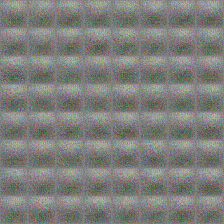

In [ ]:
#display('results/cifar10/WGAN_GP/WGAN_GP_epoch001.png')
from IPython.display import Image
from torchvision.transforms import ToPILImage

#display(Image('results/cifar10/WGAN/WGAN_epoch001.png'))
display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch001.png'))


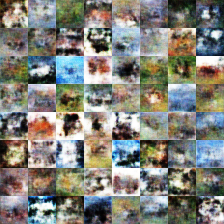

In [ ]:
#display(Image('results/cifar10/WGAN/WGAN_epoch050.png'))
display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch050.png'))

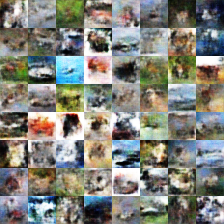

In [ ]:
#display(Image('results/cifar10/WGAN/WGAN_epoch100.png'))
display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch100.png'))

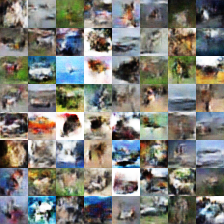

In [ ]:
#display(Image('results/cifar10/WGAN/WGAN_epoch200.png'))
display(Image('results/cifar10/WGAN_GP/WGAN_GP_epoch200.png'))